(image-segmentation:voronoi-otsu-labeling=)
# Voronoi-Otsu-Labeling
Dieser Workflow zur Bildsegmentierung ist ein relativ einfacher und dennoch leistungsfähiger Ansatz, z.B. zur Erkennung und Segmentierung von Zellkernen in Fluoreszenz-Mikroskopiebildern. Ein Zellkernmarker wie Kern-GFP, DAPI oder Histon-RFP in Kombination mit verschiedenen Mikroskopietechniken kann verwendet werden, um Bilder geeigneter Art zu erzeugen.

In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
import napari_segment_blobs_and_things_with_membranes as nsbatwm

Um den Workflow zu demonstrieren, verwenden wir Bilddaten aus der [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC022):
Wir haben den Bildsatz BBBC022v1 [Gustafsdottir et al., PLOS ONE, 2013](http://dx.doi.org/10.1371/journal.pone.0080999) verwendet, der aus der Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083) stammt.

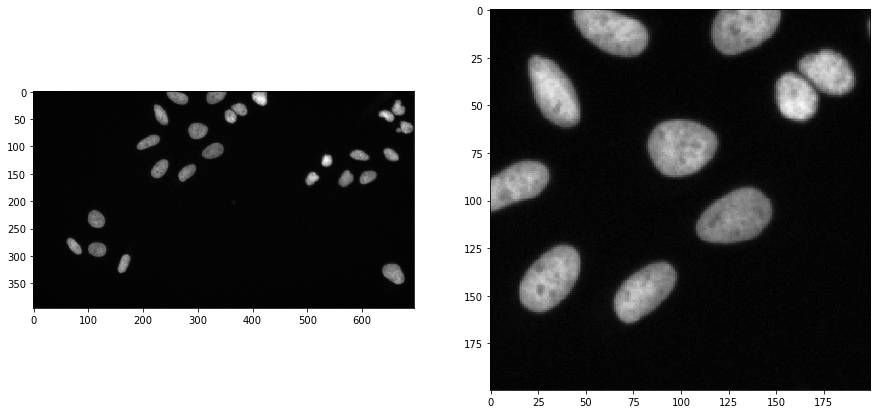

In [2]:
input_image = imread("../../data/BBBC022/IXMtest_A02_s9.tif")[:,:,0]

input_crop = input_image[0:200, 200:400]

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(input_image, plot=axs[0])
cle.imshow(input_crop, plot=axs[1])

## Anwendung des Algorithmus
Voronoi-Otsu-Labeling ist ein Befehl in clesperanto, der zwei Sigma-Parameter benötigt. Das erste Sigma steuert, wie nahe die erkannten Zellen beieinander liegen können (`spot_sigma`), und das zweite steuert, wie genau die segmentierten Objekte umrissen werden (`outline_sigma`).

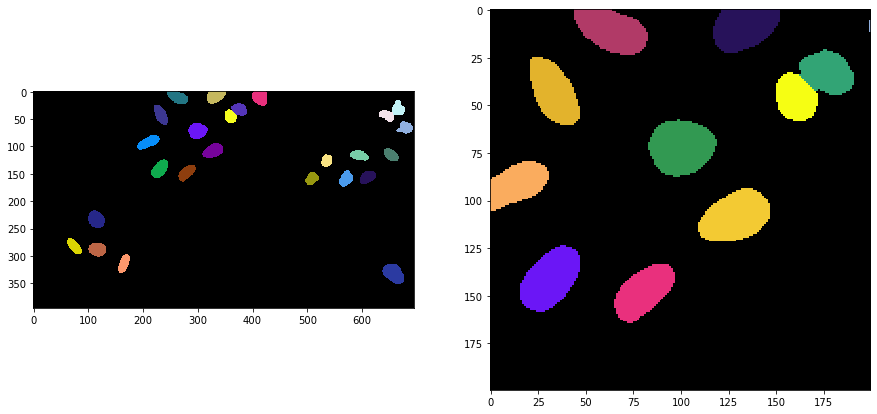

In [3]:
sigma_spot_detection = 5
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(input_image, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)
segmented_crop = segmented[0:200, 200:400]

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(segmented, labels=True, plot=axs[0])
cle.imshow(segmented_crop, labels=True, plot=axs[1])

## Wie funktioniert es?
Der Voronoi-Otsu-Labeling-Workflow ist eine Kombination aus Gauß-Unschärfe, Spot-Erkennung, Schwellenwertbildung und binärer Wasserscheide. Der interessierte Leser kann den [Open-Source-Code](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/pyclesperanto_prototype/_tier9/_voronoi_otsu_labeling.py) einsehen. Der Ansatz ähnelt der Anwendung einer Saatgut-Wasserscheide auf ein Binärbild, z.B. in [MorphoLibJ](https://imagej.net/plugins/marker-controlled-watershed) oder [scikit-image](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed). Die Saatpunkte werden jedoch automatisch berechnet und können nicht übergeben werden.

Zu Demonstrationszwecken führen wir dies nur auf dem oben gezeigten 2D-Ausschnittbild durch. Wenn dieser Algorithmus auf 3D-Daten angewendet wird, empfiehlt es sich, diese zuerst isotrop zu machen.

In [4]:
image_to_segment = input_crop
print(image_to_segment.shape)

(200, 200)


Als ersten Schritt verwischen wir das Bild mit einem gegebenen Sigma und erkennen Maxima im resultierenden Bild.

number of detected spots 29.0


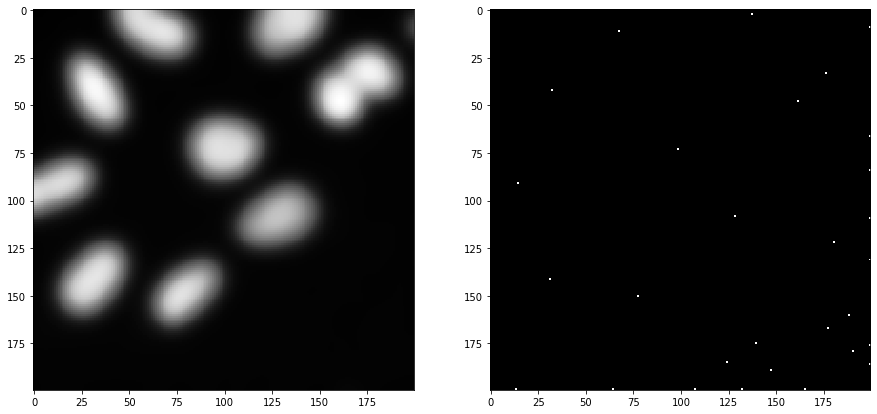

In [5]:
blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_spot_detection, sigma_y=sigma_spot_detection, sigma_z=sigma_spot_detection)

detected_spots = cle.detect_maxima_box(blurred, radius_x=0, radius_y=0, radius_z=0)

number_of_spots = cle.sum_of_all_pixels(detected_spots)
print("Anzahl der erkannten Spots", number_of_spots)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(blurred, plot=axs[0])
cle.imshow(detected_spots, plot=axs[1])

Weiterhin beginnen wir erneut mit dem zugeschnittenen Bild und verwischen es wieder, diesmal mit einem anderen Sigma. Anschließend wenden wir einen Schwellenwert auf das Bild an, wobei wir [Otsus Schwellenwertmethode (Otsu et al 1979)](https://doi.org/10.1109%2FTSMC.1979.4310076) verwenden.

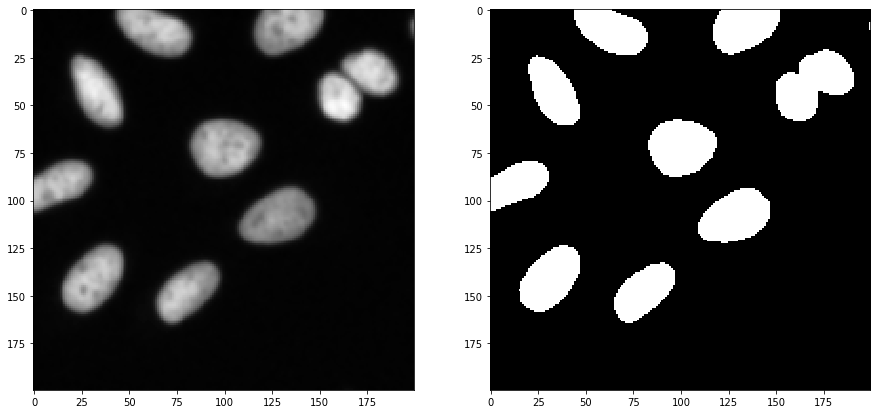

In [6]:
blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)

binary = cle.threshold_otsu(blurred)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(blurred, plot=axs[0])
cle.imshow(binary, plot=axs[1])

Anschließend nehmen wir das binäre Spots-Bild und das binäre Segmentierungsbild und wenden eine `binary_and`-Operation an, um Spots auszuschließen, die im Hintergrundbereich erkannt wurden. Diese entsprechen wahrscheinlich Rauschen.

number of selected spots 11.0


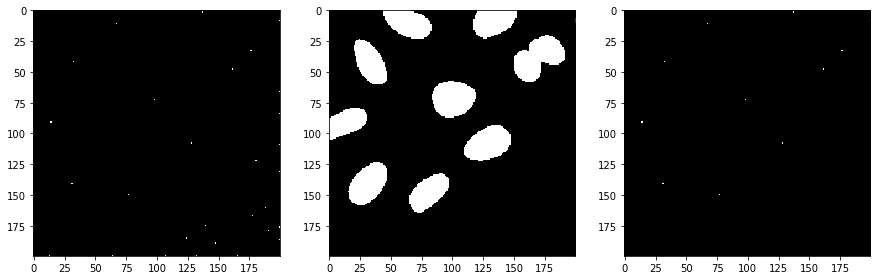

In [7]:
selected_spots = cle.binary_and(binary, detected_spots)

number_of_spots = cle.sum_of_all_pixels(selected_spots)
print("Anzahl der ausgewählten Spots", number_of_spots)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(detected_spots, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(selected_spots, plot=axs[2])

Als nächstes trennen wir den Bildraum zwischen den ausgewählten Spots mithilfe eines [Voronoi-Diagramms](https://en.wikipedia.org/wiki/Voronoi_diagram#References), das auf die positiven Pixel im Binärbild beschränkt ist.

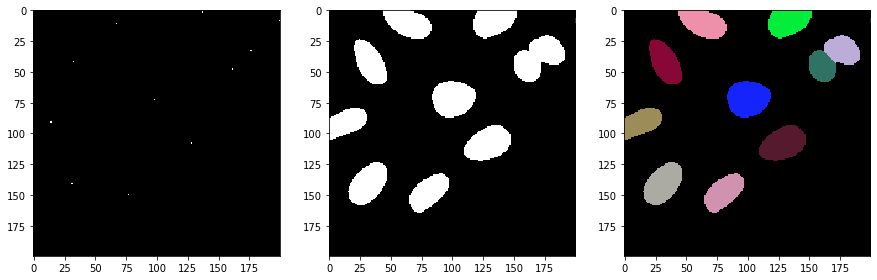

In [8]:
voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(selected_spots, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(voronoi_diagram, labels=True, plot=axs[2])

## Andere Implementierungen von Voronoi-Otsu-Labeling

Es gibt eine alternative Implementierung des Algorithmus im skriptfähigen napari-Plugin [napari-segment-blobs-and-things-with-membranes](https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes).

Der Code hier ist fast identisch mit dem Code oben. Der Hauptunterschied besteht darin, dass wir `nsbatwm.voronoi_otsu_labeling()` anstelle von `cle.voronoi_otsu_labeling()` aufrufen.

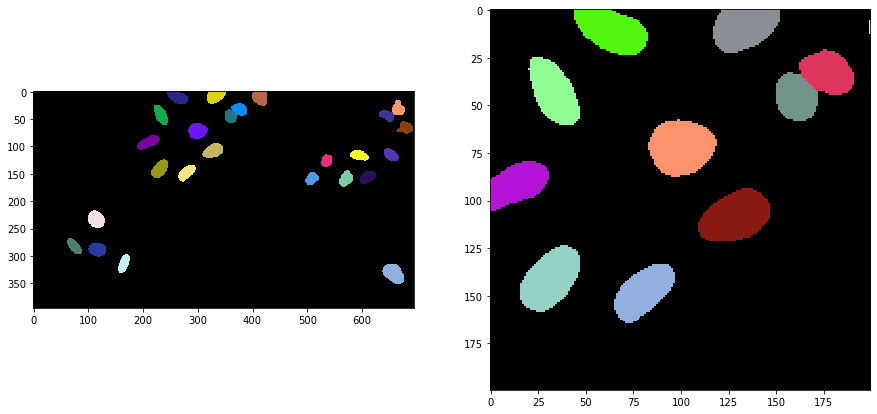

In [9]:
sigma_spot_detection = 5
sigma_outline = 1

segmented2 = nsbatwm.voronoi_otsu_labeling(input_image, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)

segmented_crop2 = segmented2[0:200, 200:400]

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(segmented2, labels=True, plot=axs[0])
cle.imshow(segmented_crop2, labels=True, plot=axs[1])